# Structure

* ### [Device Set Up](#device)
* ### [Dataset](#data)
* ### [Primitive FCNN](#primitive_fcnn)
* ### [Leaky FCNN](#leaky_fcnn)
* ### [Leaky FCNN with He Initialization](#leaky_fcnn_with_he_initialization)
* ### [Leaky FCNN with He Initialization and Dropout](#leaky_fcnn_with_he_initialization_and_dropout)
* ### [Leaky FCNN with He Initialization and BatchNorm](#leaky_fcnn_with_he_initialization_and_batchnorm)

In [1]:
import numpy as np

from torchvision import datasets, transforms
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from cnn_s.primitive_fcnn import primitiveFCNN
from cnn_s.leaky_fcnn import leakyFCNN
from cnn_s.he_init_leaky_fcnn import leakyFCNN_he
from cnn_s.leaky_he_dropout_fcnn import leakyFCNN_he_dropout
from cnn_s.leaky_he_batchnorm_fcnn import leakyFCNN_he_batchnorm
from fcnn_trainer import FCNNTrainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import inspect


In [2]:
def has_parameter(func, param_name):
    signature = inspect.signature(func)
    return param_name in signature.parameters

#### <a id='device'>Device Set up</a>

##### MacOS Apple Silicon GPU

In [3]:
#! pip3 install torch torchvision torchaudio
# Connect GPU
device = torch.device("mps")

##### Google Colab GPU

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### <a id='data'> Dataset </a>

In [5]:
class FlattenTransform():

    def __call__(self, tensor):
        return tensor.view(-1)

mnist_transform = transforms.Compose([transforms.ToTensor(),                # convert the image to a tensor
                                      FlattenTransform()])                  # flatten the tensor

# transformation are applied dynamically on the retrieval of individual items
train_dataset = datasets.MNIST(root = './data', train = True, transform = mnist_transform, download = True)
test_dataset = datasets.MNIST(root = './data', train = False, transform = mnist_transform, download = True)

In [6]:
optimizers_list = {
    "Adam": torch.optim.Adam,
}

def train(model_class: nn.Module, epochs_list: list, learning_rate: float, **kwargs) -> dict:
    additional_params = {}
    for arg, val in kwargs.items():
           if has_parameter(model_class, arg):
                  additional_params[arg] = val
    model = model_class(28 * 28, 10, **additional_params).to(device)
    trainer = FCNNTrainer(lr=learning_rate, model=model, device=device)
    trainer.prepare_loaders(train_dataset, test_dataset)
    best_parameters = {}

    for optimizer_name, optimizer_func in optimizers_list.items():
            trainer.set_optimizer(optimizer_name, optimizer_func)

            # Start training
            for ind, epoch in enumerate(epochs_list):
                    trainer.set_epochs(epoch)
                    trainer.epoch_train(epoch_val=epoch, prev_epochs=sum(epochs_list[:ind]))

                    trainer.plot_metrics(epochs=sum(epochs_list[:ind]) + epoch)

            best_epoch = trainer.test_metrics.index(min(trainer.test_metrics))
            best_epoch += 1 ## Since we count from 0
            best_parameters[optimizer_name] = {"epoch": best_epoch, "min_loss": min(trainer.test_metrics)}
            model = model_class(28 * 28, 10, **additional_params)
            trainer.clear_main_values(model, device)

            return best_parameters


In [7]:
def load_model_state(model: nn.Module, optimizer, optimizer_name: str, epoch: int, model_states_dir="./models_states"):
    model_name = f"{model.__class__.__name__}_{optimizer_name}"
    checkpoint_path = f'{model_states_dir}/{model_name}/epoch_{epoch}.pth'
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"No such file or directory: '{checkpoint_path}'")

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['test_loss']


def load_best_model(epoch: int, optimizer_name: str, model: nn.Module, **kwargs):
    additional_params = {}
    for arg, val in kwargs.items():
           if has_parameter(model, arg):
                  additional_params[arg] = val
    best_model = model(28 * 28, 10, **additional_params).to(device)
    optimizer = optimizers_list[optimizer_name](best_model.parameters(), lr=0.01)
    load_model_state(best_model, optimizer, optimizer_name, epoch)
    return best_model, optimizer

In [8]:
def test_model(model: nn.Module):
    model.eval()
    train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=True)

    with torch.no_grad():
        ### Training dataset ###
        correct, total = 0, 0
        all_preds_tr, all_labels_tr = [], []

        for x_tr, y_tr in train_loader:
            x_tr, y_tr = x_tr.to(device), y_tr.to(device)
            y_pred_tr = torch.softmax(model(x_tr), dim=1)
            # retrieve class with the highest probability
            y_pred_tr_class = torch.argmax(y_pred_tr, dim=1)

            correct += (y_pred_tr_class == y_tr).sum().item()
            total += y_tr.size(0)
            
            all_preds_tr.extend(y_pred_tr_class.cpu().numpy())
            all_labels_tr.extend(y_tr.cpu().numpy())

        train_acc = correct / total
        print(f'train_accuracy = {train_acc:.4f}')

        labels = np.sort(np.unique(all_labels_tr))
        conf_mtrx = confusion_matrix(all_labels_tr, all_preds_tr, labels=labels)
        cm_plot = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx, display_labels=labels)
        cm_plot.plot()
        plt.title('Confusion Matrix - Training')
        plt.show()

        ### Test dataset ###
        correct, total = 0, 0
        all_preds_ts, all_labels_ts = [], []

        for x_ts, y_ts in test_loader:
            x_ts, y_ts = x_ts.to(device), y_ts.to(device)
            y_pred_ts = torch.softmax(model(x_ts), dim=1)
            # retrieve class with the highest probability
            y_pred_ts_class = torch.argmax(y_pred_ts, dim=1)

            correct += (y_pred_ts_class == y_ts).sum().item()
            total += y_ts.size(0)

            all_preds_ts.extend(y_pred_ts_class.cpu().numpy())
            all_labels_ts.extend(y_ts.cpu().numpy())

        test_acc = correct / total
        print(f'test_accuracy = {test_acc:.4f}')

        labels = np.sort(np.unique(all_labels_ts))
        conf_mtrx = confusion_matrix(all_labels_ts, all_preds_ts, labels=labels)
        cm_plot = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx, display_labels=labels)
        cm_plot.plot()
        plt.title('Confusion Matrix - Test')
        plt.show()


#### <a id='primitive_fcnn'>Primitive FCNN </a>

Train Epoch: 0 	 [Train Loss]: 2.338844 	 [Test Loss]: 3.498120
Train Epoch: 1 	 [Train Loss]: 3.475210 	 [Test Loss]: 2.835669
Train Epoch: 2 	 [Train Loss]: 2.818452 	 [Test Loss]: 2.328054
Train Epoch: 3 	 [Train Loss]: 2.357267 	 [Test Loss]: 2.299553
Train Epoch: 4 	 [Train Loss]: 2.286316 	 [Test Loss]: 2.310210
Train Epoch: 5 	 [Train Loss]: 2.268176 	 [Test Loss]: 2.252930
Train Epoch: 6 	 [Train Loss]: 2.233205 	 [Test Loss]: 2.179685
Train Epoch: 7 	 [Train Loss]: 2.176184 	 [Test Loss]: 2.070226
Train Epoch: 8 	 [Train Loss]: 2.051032 	 [Test Loss]: 1.967068
Train Epoch: 9 	 [Train Loss]: 1.973181 	 [Test Loss]: 1.849158
Train Epoch: 10 	 [Train Loss]: 1.852001 	 [Test Loss]: 1.764684
Train Epoch: 11 	 [Train Loss]: 1.762556 	 [Test Loss]: 1.632071
Train Epoch: 12 	 [Train Loss]: 1.630856 	 [Test Loss]: 1.452527
Train Epoch: 13 	 [Train Loss]: 1.486634 	 [Test Loss]: 1.359006
Train Epoch: 14 	 [Train Loss]: 1.350707 	 [Test Loss]: 1.230417
Train Epoch: 15 	 [Train Loss]: 1.2

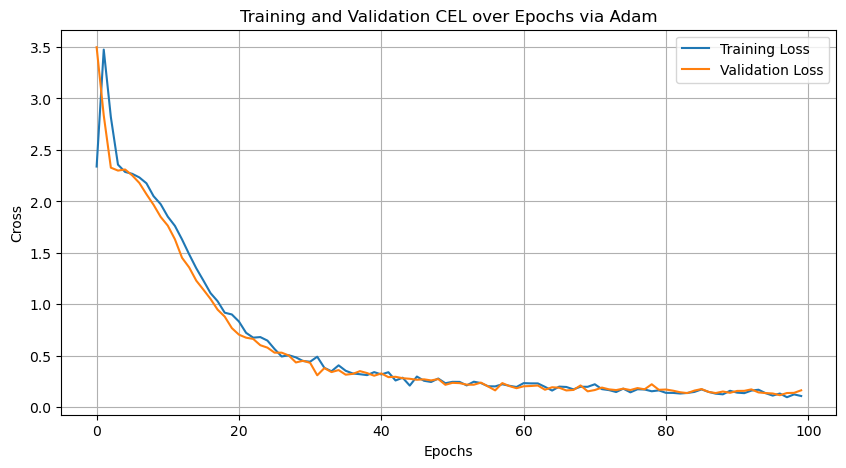

Train Epoch: 0 	 [Train Loss]: 0.109588 	 [Test Loss]: 0.166185
Train Epoch: 1 	 [Train Loss]: 0.128341 	 [Test Loss]: 0.167045
Train Epoch: 2 	 [Train Loss]: 0.110141 	 [Test Loss]: 0.109565
Train Epoch: 3 	 [Train Loss]: 0.136906 	 [Test Loss]: 0.150999
Train Epoch: 4 	 [Train Loss]: 0.134502 	 [Test Loss]: 0.154110
Train Epoch: 5 	 [Train Loss]: 0.151182 	 [Test Loss]: 0.104283
Train Epoch: 6 	 [Train Loss]: 0.109862 	 [Test Loss]: 0.127776
Train Epoch: 7 	 [Train Loss]: 0.160469 	 [Test Loss]: 0.137436
Train Epoch: 8 	 [Train Loss]: 0.125224 	 [Test Loss]: 0.128845
Train Epoch: 9 	 [Train Loss]: 0.152484 	 [Test Loss]: 0.166510
Train Epoch: 10 	 [Train Loss]: 0.107833 	 [Test Loss]: 0.137662
Train Epoch: 11 	 [Train Loss]: 0.108433 	 [Test Loss]: 0.096669
Train Epoch: 12 	 [Train Loss]: 0.152077 	 [Test Loss]: 0.135368
Train Epoch: 13 	 [Train Loss]: 0.100815 	 [Test Loss]: 0.138738
Train Epoch: 14 	 [Train Loss]: 0.135368 	 [Test Loss]: 0.114293
Train Epoch: 15 	 [Train Loss]: 0.1

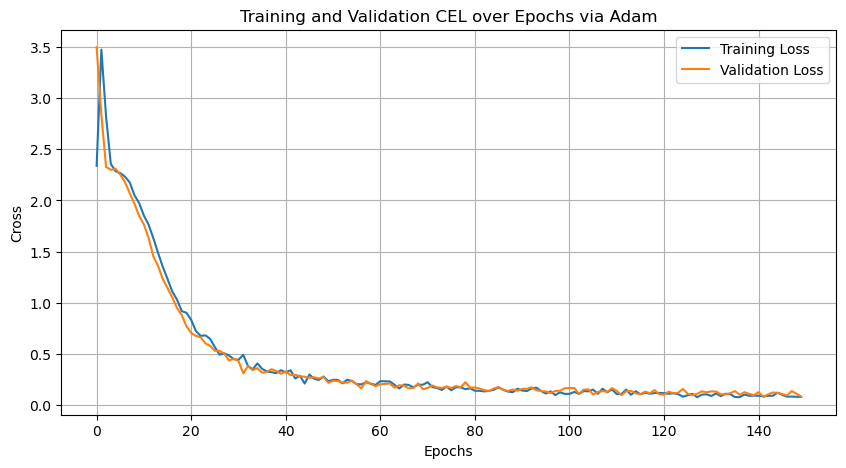

In [9]:
# Train
learning_rate = 0.01
epochs_list = [100, 50]

best_parameters = train(primitiveFCNN, epochs_list, learning_rate)

train_accuracy = 0.9728


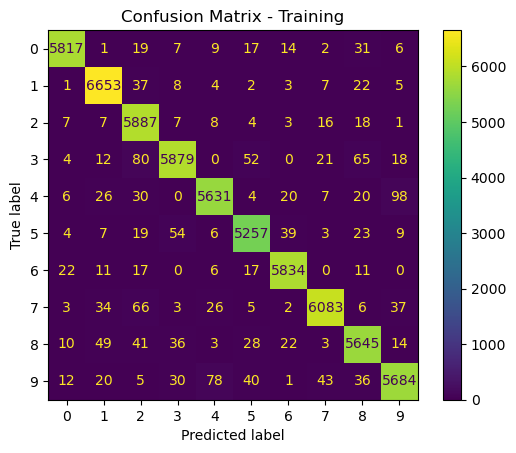

test_accuracy = 0.9644


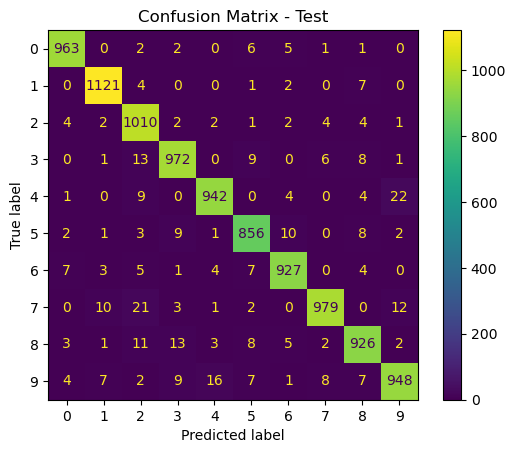

In [10]:
# Test
optimizer_name = min(best_parameters, key=lambda k: best_parameters[k]['min_loss'])
epochs = best_parameters[optimizer_name]['epoch']
final_model, _ = load_best_model(epochs, optimizer_name, primitiveFCNN)
test_model(final_model)

#### <a id='leaky_fcnn'>Leaky FCNN </a>

Train Epoch: 0 	 [Train Loss]: 2.303978 	 [Test Loss]: 1.960491
Train Epoch: 1 	 [Train Loss]: 1.948128 	 [Test Loss]: 2.243168
Train Epoch: 2 	 [Train Loss]: 2.309412 	 [Test Loss]: 1.426646
Train Epoch: 3 	 [Train Loss]: 1.434872 	 [Test Loss]: 1.525212
Train Epoch: 4 	 [Train Loss]: 1.397828 	 [Test Loss]: 1.177377
Train Epoch: 5 	 [Train Loss]: 1.216339 	 [Test Loss]: 0.795840
Train Epoch: 6 	 [Train Loss]: 0.820022 	 [Test Loss]: 0.685140
Train Epoch: 7 	 [Train Loss]: 0.652378 	 [Test Loss]: 0.720097
Train Epoch: 8 	 [Train Loss]: 0.742845 	 [Test Loss]: 0.534583
Train Epoch: 9 	 [Train Loss]: 0.565603 	 [Test Loss]: 0.423324
Train Epoch: 10 	 [Train Loss]: 0.435370 	 [Test Loss]: 0.474379
Train Epoch: 11 	 [Train Loss]: 0.473578 	 [Test Loss]: 0.406493
Train Epoch: 12 	 [Train Loss]: 0.496266 	 [Test Loss]: 0.407352
Train Epoch: 13 	 [Train Loss]: 0.418735 	 [Test Loss]: 0.426499
Train Epoch: 14 	 [Train Loss]: 0.323106 	 [Test Loss]: 0.441638
Train Epoch: 15 	 [Train Loss]: 0.3

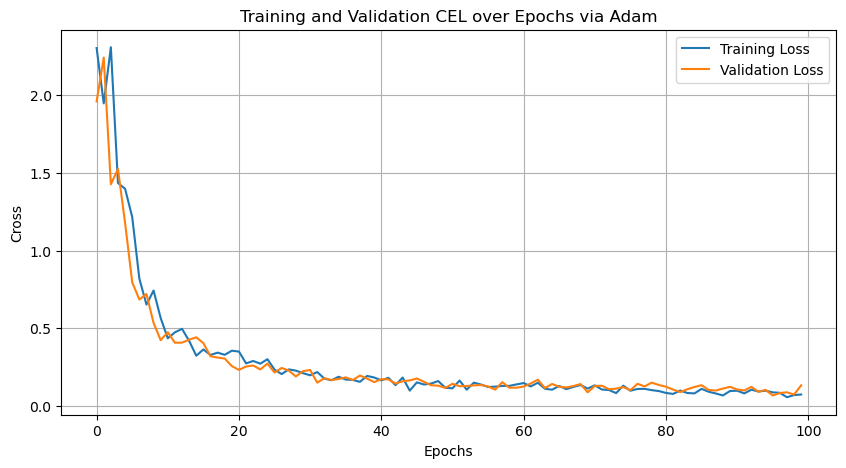

Train Epoch: 0 	 [Train Loss]: 0.081482 	 [Test Loss]: 0.133702
Train Epoch: 1 	 [Train Loss]: 0.084211 	 [Test Loss]: 0.111634
Train Epoch: 2 	 [Train Loss]: 0.064779 	 [Test Loss]: 0.092260
Train Epoch: 3 	 [Train Loss]: 0.077275 	 [Test Loss]: 0.103491
Train Epoch: 4 	 [Train Loss]: 0.083283 	 [Test Loss]: 0.116116
Train Epoch: 5 	 [Train Loss]: 0.096320 	 [Test Loss]: 0.071506
Train Epoch: 6 	 [Train Loss]: 0.072310 	 [Test Loss]: 0.092672
Train Epoch: 7 	 [Train Loss]: 0.101838 	 [Test Loss]: 0.115304
Train Epoch: 8 	 [Train Loss]: 0.062370 	 [Test Loss]: 0.095560
Train Epoch: 9 	 [Train Loss]: 0.098166 	 [Test Loss]: 0.124626
Train Epoch: 10 	 [Train Loss]: 0.055245 	 [Test Loss]: 0.113905
Train Epoch: 11 	 [Train Loss]: 0.061994 	 [Test Loss]: 0.087473
Train Epoch: 12 	 [Train Loss]: 0.101429 	 [Test Loss]: 0.102877
Train Epoch: 13 	 [Train Loss]: 0.062853 	 [Test Loss]: 0.122416
Train Epoch: 14 	 [Train Loss]: 0.091739 	 [Test Loss]: 0.085946
Train Epoch: 15 	 [Train Loss]: 0.0

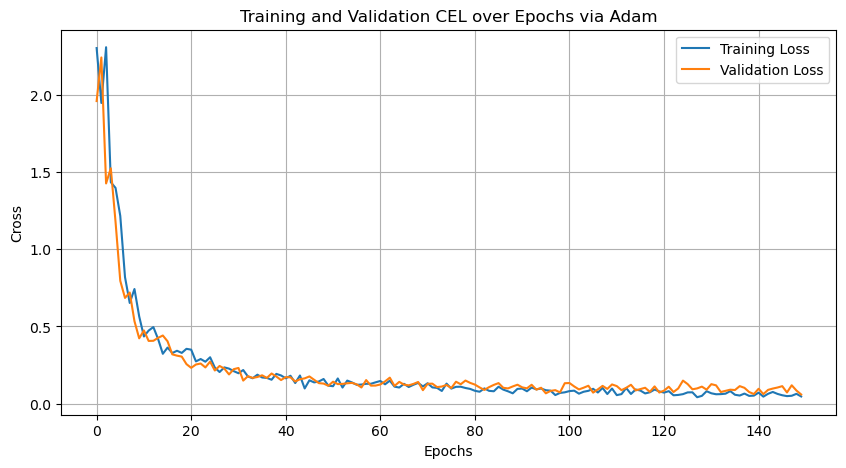

In [11]:
# Train
learning_rate = 0.01
epochs_list = [100, 50]

best_parameters = train(leakyFCNN, epochs_list, learning_rate)

train_accuracy = 0.9814


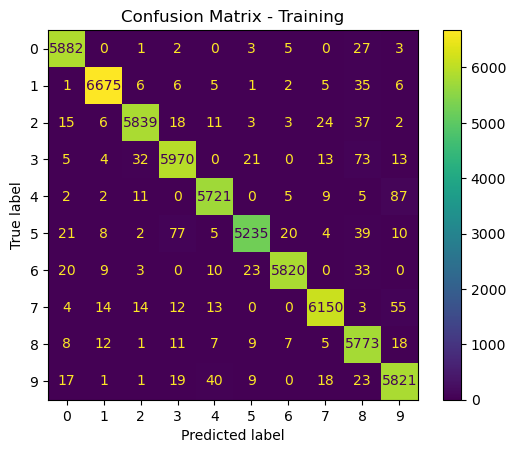

test_accuracy = 0.9730


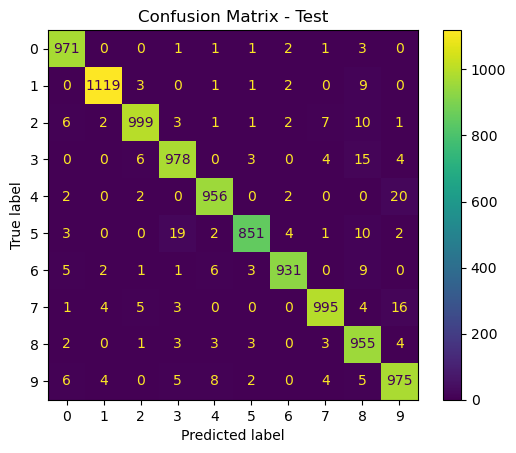

In [12]:
# Test
optimizer_name = min(best_parameters, key=lambda k: best_parameters[k]['min_loss'])
epochs = best_parameters[optimizer_name]['epoch']
final_model, _ = load_best_model(epochs, optimizer_name, leakyFCNN)
test_model(final_model)

#### <a id='leaky_fcnn_with_he_initialization'> Leaky FCNN with HE initialization </a>

Train Epoch: 0 	 [Train Loss]: 7.598473 	 [Test Loss]: 34.389725
Train Epoch: 1 	 [Train Loss]: 36.041702 	 [Test Loss]: 24.449547
Train Epoch: 2 	 [Train Loss]: 28.216108 	 [Test Loss]: 31.768364
Train Epoch: 3 	 [Train Loss]: 31.278967 	 [Test Loss]: 31.247000
Train Epoch: 4 	 [Train Loss]: 30.527914 	 [Test Loss]: 23.318165
Train Epoch: 5 	 [Train Loss]: 23.779079 	 [Test Loss]: 12.819172
Train Epoch: 6 	 [Train Loss]: 12.975219 	 [Test Loss]: 8.269543
Train Epoch: 7 	 [Train Loss]: 7.414904 	 [Test Loss]: 4.113577
Train Epoch: 8 	 [Train Loss]: 3.879142 	 [Test Loss]: 2.934045
Train Epoch: 9 	 [Train Loss]: 2.717086 	 [Test Loss]: 2.149646
Train Epoch: 10 	 [Train Loss]: 2.109488 	 [Test Loss]: 2.195393
Train Epoch: 11 	 [Train Loss]: 2.080427 	 [Test Loss]: 2.018200
Train Epoch: 12 	 [Train Loss]: 1.927512 	 [Test Loss]: 1.464306
Train Epoch: 13 	 [Train Loss]: 1.417156 	 [Test Loss]: 1.060026
Train Epoch: 14 	 [Train Loss]: 1.104718 	 [Test Loss]: 0.891121
Train Epoch: 15 	 [Trai

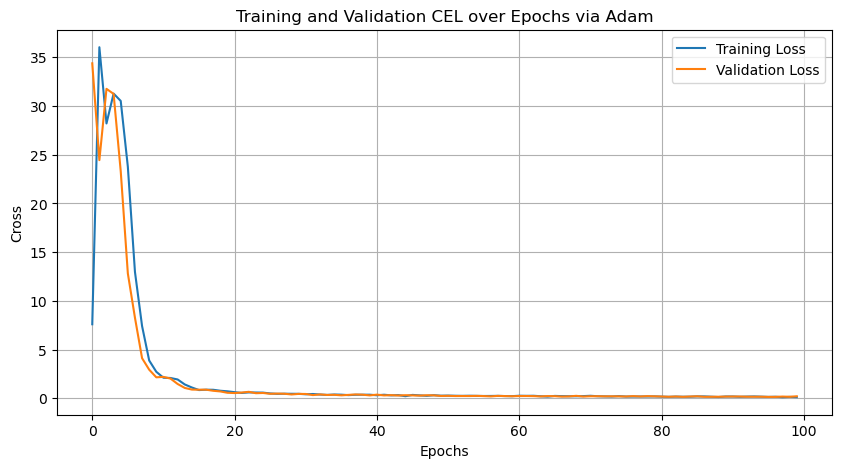

Train Epoch: 0 	 [Train Loss]: 0.138907 	 [Test Loss]: 0.189576
Train Epoch: 1 	 [Train Loss]: 0.150341 	 [Test Loss]: 0.170286
Train Epoch: 2 	 [Train Loss]: 0.125220 	 [Test Loss]: 0.130996
Train Epoch: 3 	 [Train Loss]: 0.130059 	 [Test Loss]: 0.180520
Train Epoch: 4 	 [Train Loss]: 0.150937 	 [Test Loss]: 0.179795
Train Epoch: 5 	 [Train Loss]: 0.161201 	 [Test Loss]: 0.125517
Train Epoch: 6 	 [Train Loss]: 0.147329 	 [Test Loss]: 0.146409
Train Epoch: 7 	 [Train Loss]: 0.175797 	 [Test Loss]: 0.151081
Train Epoch: 8 	 [Train Loss]: 0.132493 	 [Test Loss]: 0.132540
Train Epoch: 9 	 [Train Loss]: 0.159595 	 [Test Loss]: 0.170604
Train Epoch: 10 	 [Train Loss]: 0.130310 	 [Test Loss]: 0.152513
Train Epoch: 11 	 [Train Loss]: 0.122579 	 [Test Loss]: 0.116054
Train Epoch: 12 	 [Train Loss]: 0.167661 	 [Test Loss]: 0.134970
Train Epoch: 13 	 [Train Loss]: 0.123925 	 [Test Loss]: 0.167275
Train Epoch: 14 	 [Train Loss]: 0.155250 	 [Test Loss]: 0.134418
Train Epoch: 15 	 [Train Loss]: 0.1

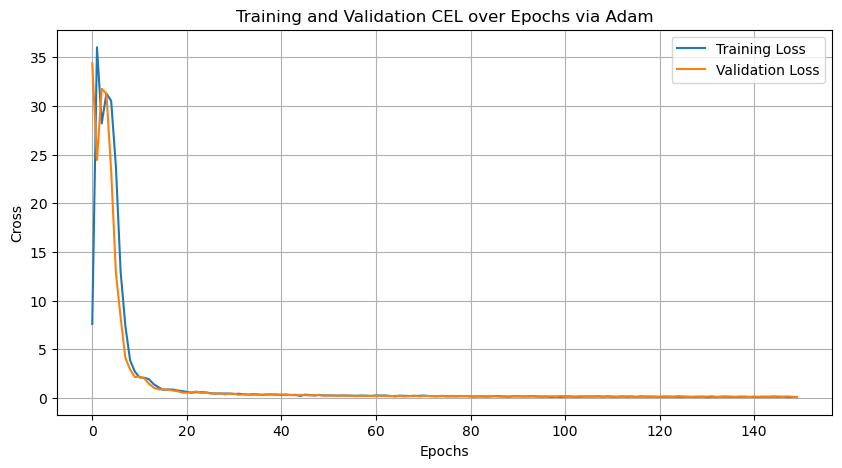

In [13]:
# Train
learning_rate = 0.01
epochs_list = [100, 50]

best_parameters = train(leakyFCNN_he, epochs_list, learning_rate)

train_accuracy = 0.9668


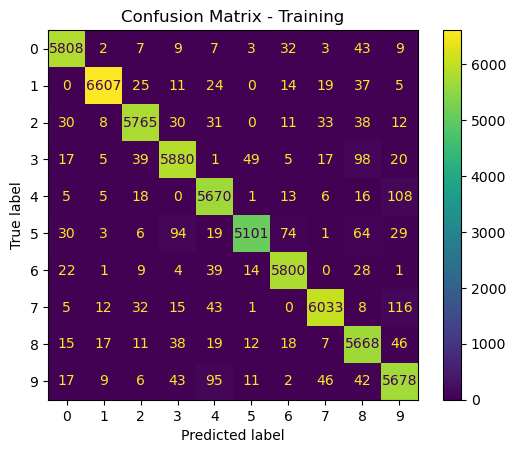

test_accuracy = 0.9625


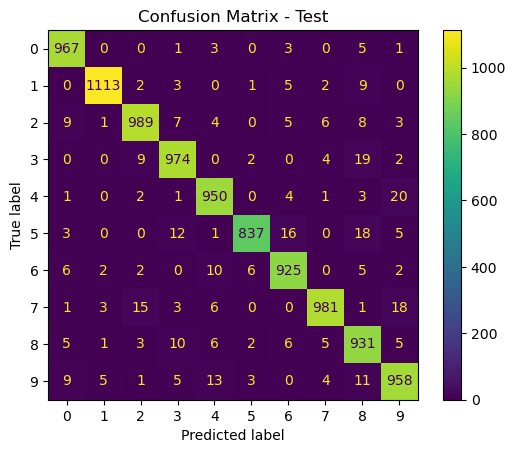

In [14]:
# Test
optimizer_name = min(best_parameters, key=lambda k: best_parameters[k]['min_loss'])
epochs = best_parameters[optimizer_name]['epoch']
final_model, _ = load_best_model(epochs, optimizer_name, leakyFCNN_he)
test_model(final_model)

#### <a id='leaky_fcnn_with_he_initialization_and_dropout'> Leaky FCNN with HE initialization and Dropout </a>

Train Epoch: 0 	 [Train Loss]: 7.208786 	 [Test Loss]: 20.484062
Train Epoch: 1 	 [Train Loss]: 21.008741 	 [Test Loss]: 22.250608
Train Epoch: 2 	 [Train Loss]: 22.019136 	 [Test Loss]: 14.388746
Train Epoch: 3 	 [Train Loss]: 14.230685 	 [Test Loss]: 9.007902
Train Epoch: 4 	 [Train Loss]: 8.633429 	 [Test Loss]: 4.631831
Train Epoch: 5 	 [Train Loss]: 4.630024 	 [Test Loss]: 1.988620
Train Epoch: 6 	 [Train Loss]: 2.015391 	 [Test Loss]: 3.197581
Train Epoch: 7 	 [Train Loss]: 3.106370 	 [Test Loss]: 1.936867
Train Epoch: 8 	 [Train Loss]: 1.977288 	 [Test Loss]: 1.301691
Train Epoch: 9 	 [Train Loss]: 1.417676 	 [Test Loss]: 0.898086
Train Epoch: 10 	 [Train Loss]: 0.945089 	 [Test Loss]: 0.897458
Train Epoch: 11 	 [Train Loss]: 0.958086 	 [Test Loss]: 0.871900
Train Epoch: 12 	 [Train Loss]: 1.000837 	 [Test Loss]: 0.826160
Train Epoch: 13 	 [Train Loss]: 0.896423 	 [Test Loss]: 0.769726
Train Epoch: 14 	 [Train Loss]: 0.746044 	 [Test Loss]: 0.670041
Train Epoch: 15 	 [Train Loss

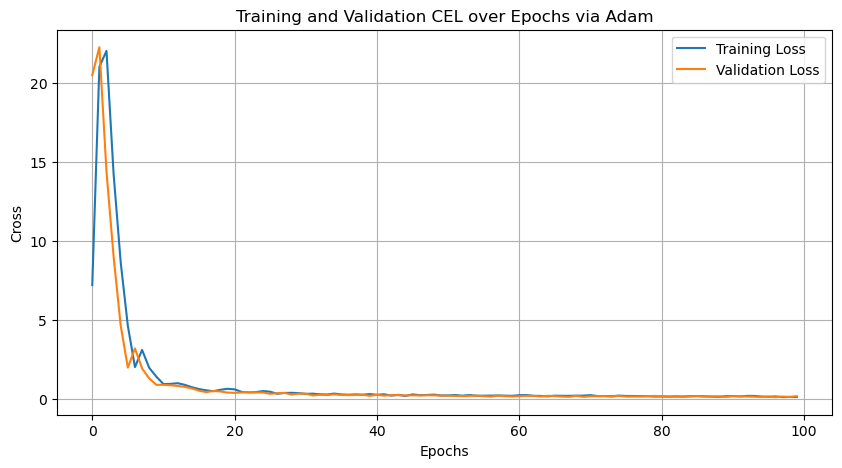

Train Epoch: 0 	 [Train Loss]: 0.135910 	 [Test Loss]: 0.198194
Train Epoch: 1 	 [Train Loss]: 0.148665 	 [Test Loss]: 0.157117
Train Epoch: 2 	 [Train Loss]: 0.134593 	 [Test Loss]: 0.132218
Train Epoch: 3 	 [Train Loss]: 0.144137 	 [Test Loss]: 0.148230
Train Epoch: 4 	 [Train Loss]: 0.136903 	 [Test Loss]: 0.160693
Train Epoch: 5 	 [Train Loss]: 0.173666 	 [Test Loss]: 0.109096
Train Epoch: 6 	 [Train Loss]: 0.146930 	 [Test Loss]: 0.122352
Train Epoch: 7 	 [Train Loss]: 0.177246 	 [Test Loss]: 0.132622
Train Epoch: 8 	 [Train Loss]: 0.132511 	 [Test Loss]: 0.136042
Train Epoch: 9 	 [Train Loss]: 0.167267 	 [Test Loss]: 0.145743
Train Epoch: 10 	 [Train Loss]: 0.129418 	 [Test Loss]: 0.130883
Train Epoch: 11 	 [Train Loss]: 0.136539 	 [Test Loss]: 0.102283
Train Epoch: 12 	 [Train Loss]: 0.167845 	 [Test Loss]: 0.141208
Train Epoch: 13 	 [Train Loss]: 0.125342 	 [Test Loss]: 0.164109
Train Epoch: 14 	 [Train Loss]: 0.172089 	 [Test Loss]: 0.119912
Train Epoch: 15 	 [Train Loss]: 0.1

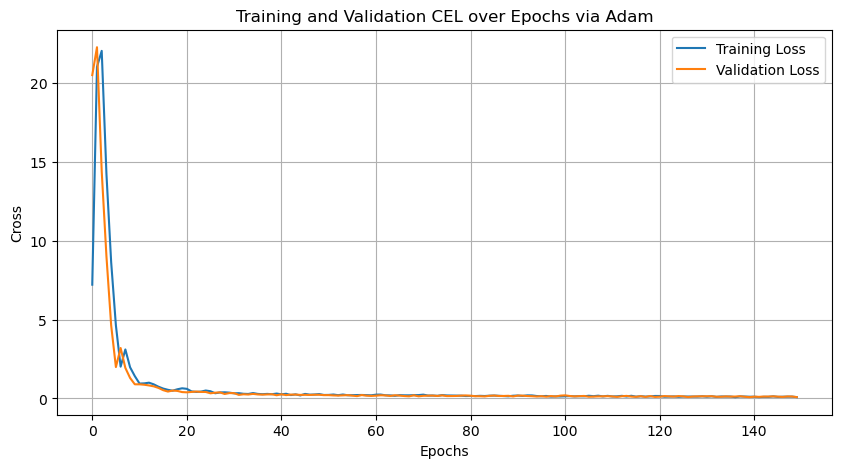

In [15]:
# Train
learning_rate = 0.01
epochs_list = [100, 50]
p = 0.03

best_parameters = train(leakyFCNN_he_dropout, epochs_list, learning_rate, p=p)

train_accuracy = 0.9685


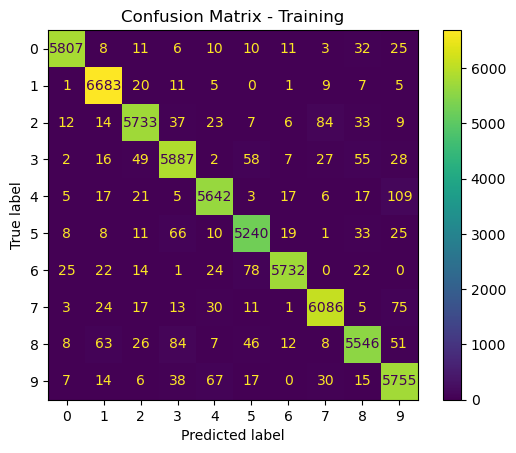

test_accuracy = 0.9619


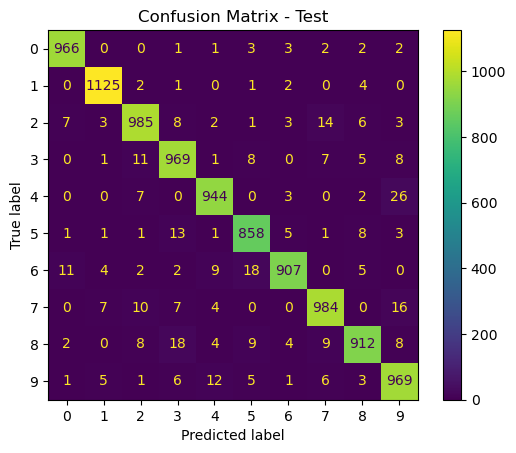

In [16]:
# Test
optimizer_name = min(best_parameters, key=lambda k: best_parameters[k]['min_loss'])
epochs = best_parameters[optimizer_name]['epoch']
final_model, _ = load_best_model(epochs, optimizer_name, leakyFCNN_he_dropout, p=p)
test_model(final_model)

#### <a id='leaky_fcnn_with_he_initialization_and_batchnorm'> Leaky FCNN with HE initialization and BatchNorm </a>

Train Epoch: 0 	 [Train Loss]: 12.433730 	 [Test Loss]: 5.583291
Train Epoch: 1 	 [Train Loss]: 3.406964 	 [Test Loss]: 4.742811
Train Epoch: 2 	 [Train Loss]: 1.942520 	 [Test Loss]: 4.591270
Train Epoch: 3 	 [Train Loss]: 1.521306 	 [Test Loss]: 3.805221
Train Epoch: 4 	 [Train Loss]: 1.052821 	 [Test Loss]: 2.308003
Train Epoch: 5 	 [Train Loss]: 1.056837 	 [Test Loss]: 2.193557
Train Epoch: 6 	 [Train Loss]: 0.940783 	 [Test Loss]: 1.777731
Train Epoch: 7 	 [Train Loss]: 0.745782 	 [Test Loss]: 1.522258
Train Epoch: 8 	 [Train Loss]: 0.675062 	 [Test Loss]: 1.348142
Train Epoch: 9 	 [Train Loss]: 0.691293 	 [Test Loss]: 1.084064
Train Epoch: 10 	 [Train Loss]: 0.558947 	 [Test Loss]: 1.033282
Train Epoch: 11 	 [Train Loss]: 0.482561 	 [Test Loss]: 0.808923
Train Epoch: 12 	 [Train Loss]: 0.487659 	 [Test Loss]: 0.908174
Train Epoch: 13 	 [Train Loss]: 0.456659 	 [Test Loss]: 0.869297
Train Epoch: 14 	 [Train Loss]: 0.403866 	 [Test Loss]: 0.773975
Train Epoch: 15 	 [Train Loss]: 0.

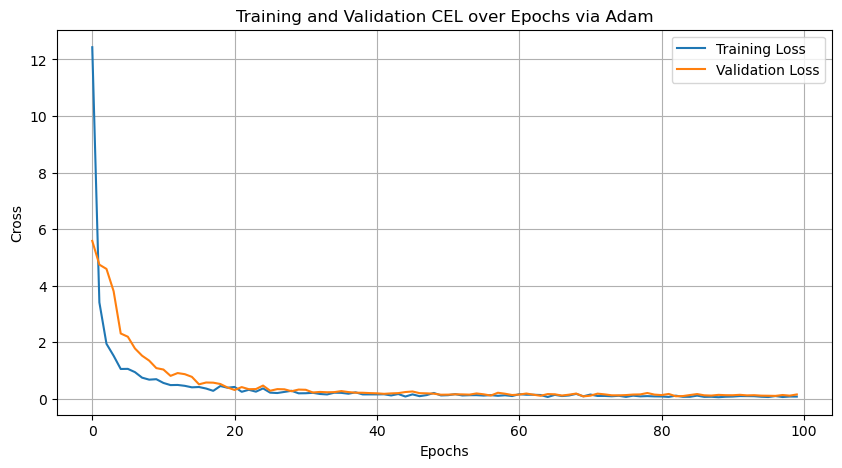

Train Epoch: 0 	 [Train Loss]: 0.078371 	 [Test Loss]: 0.103984
Train Epoch: 1 	 [Train Loss]: 0.072200 	 [Test Loss]: 0.146332
Train Epoch: 2 	 [Train Loss]: 0.064139 	 [Test Loss]: 0.093600
Train Epoch: 3 	 [Train Loss]: 0.063184 	 [Test Loss]: 0.092327
Train Epoch: 4 	 [Train Loss]: 0.059439 	 [Test Loss]: 0.149617
Train Epoch: 5 	 [Train Loss]: 0.067107 	 [Test Loss]: 0.098916
Train Epoch: 6 	 [Train Loss]: 0.068828 	 [Test Loss]: 0.135176
Train Epoch: 7 	 [Train Loss]: 0.074058 	 [Test Loss]: 0.113210
Train Epoch: 8 	 [Train Loss]: 0.055700 	 [Test Loss]: 0.106281
Train Epoch: 9 	 [Train Loss]: 0.084778 	 [Test Loss]: 0.135068
Train Epoch: 10 	 [Train Loss]: 0.059245 	 [Test Loss]: 0.126119
Train Epoch: 11 	 [Train Loss]: 0.047592 	 [Test Loss]: 0.103752
Train Epoch: 12 	 [Train Loss]: 0.084338 	 [Test Loss]: 0.130777
Train Epoch: 13 	 [Train Loss]: 0.056703 	 [Test Loss]: 0.129807
Train Epoch: 14 	 [Train Loss]: 0.077466 	 [Test Loss]: 0.103571
Train Epoch: 15 	 [Train Loss]: 0.0

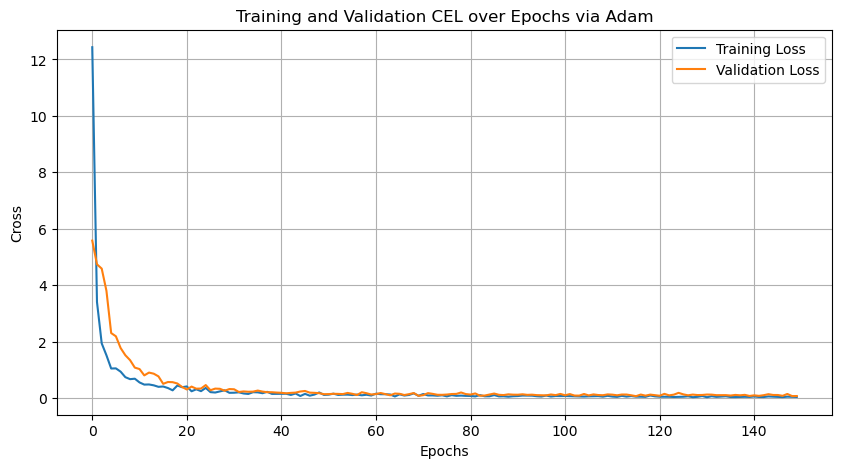

In [17]:
# Train
learning_rate = 0.01
epochs_list = [100, 50]

best_parameters = train(leakyFCNN_he_batchnorm, epochs_list, learning_rate)

train_accuracy = 0.9834


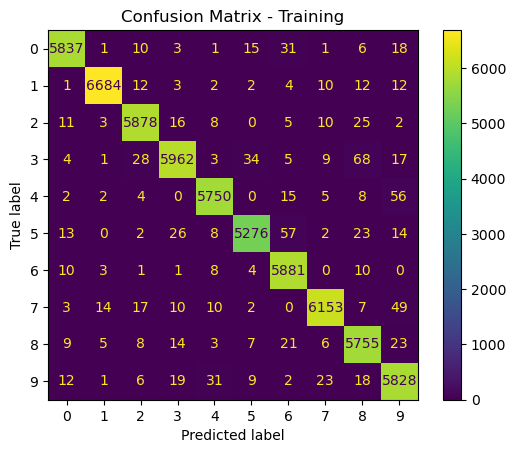

test_accuracy = 0.9686


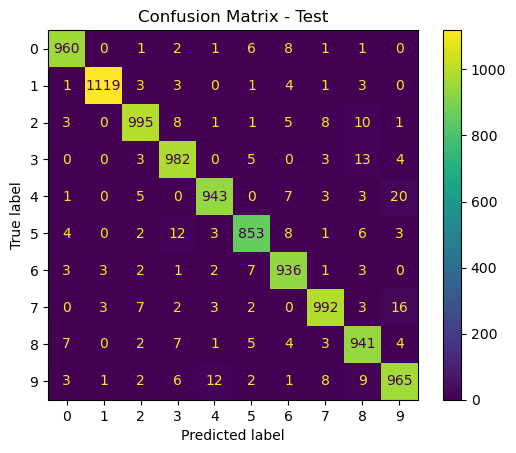

In [18]:
# Test
optimizer_name = min(best_parameters, key=lambda k: best_parameters[k]['min_loss'])
epochs = best_parameters[optimizer_name]['epoch']
final_model, _ = load_best_model(epochs, optimizer_name, leakyFCNN_he_batchnorm)
test_model(final_model)